Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from torchvision.io import read_image

import time
import copy

import torchvision
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
import os

from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Pad, Compose,CenterCrop, ToPILImage, Normalize, ConvertImageDtype, Resize, transforms
from torch.utils.data import DataLoader
from torch.functional import F

import matplotlib.pyplot as plt

Dataset Class, DatasetLoader

In [5]:
#create class for the GTSRB dataset.
class GTSRB(Dataset):
    def __init__(self, annotations_file, img_dir , transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)[["Path","ClassId"]] #gets the labels for each image
        self.img_dir = img_dir #image directory
        self.transform = transform #transformations for image
        self.target_transform = target_transform #transformation for label

    def __len__(self):
        return len(self.img_labels) #get length of the dataset

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]) #gets the path for the image
        label = self.img_labels.iloc[idx, 1]
        image = read_image(img_path) #get image
        if self.transform:
            image = self.transform(image) #transform the image
        if self.target_transform:
            label = self.target_transform(label) #transform the label
        return image, label 

Get data, Transform the data

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(224), # randomly cropped a section of the image and resize it to 224 x 224
        transforms.RandomHorizontalFlip(), # randomly flipped an image given a probability, by default 0.5
        transforms.ToTensor(), #convert image to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #normalize the image
    ]), #transformations for the training set
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224), #ensures images are 224 x 224
        transforms.CenterCrop(224), #crops image by center to reduce background noise
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), #transformations for the testing set
}

data_loc = 'traffic_data' #folder name

test_csv = data_loc+"/Test.csv" #path for test images annotations
test_data = GTSRB(img_dir = data_loc, annotations_file = test_csv,
                  transform = data_transforms["test"]) #get the training dataset

train_csv = data_loc+"/Train.csv" #path for train images annotations
train_data = GTSRB(img_dir = data_loc, annotations_file = train_csv,
                  transform = data_transforms["train"]) #get the testing dataset

dataset_loader ={
    "train" : DataLoader(train_data, batch_size=10, shuffle=True), #dataloader for train set for processing
    "test" : DataLoader(test_data, batch_size=10, shuffle=True) #dataloader for test set for processing
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Helper Functions and Dataset statistics

In [ ]:
#display an image, used SOURCE[1] as guide
def showimg(img, title=None):
    img = img.numpy().transpose((1, 2, 0)) # flip tensor for displaying as image 

    mean = np.array([0.485, 0.456, 0.406]) #get mean of images
    std = np.array([0.229, 0.224, 0.225])   #get standard deviation of images
    img = std * img + mean #reverse changes from the tranformation
    img = np.clip(img, 0, 1) #clip images to range 0 -1
    plt.imshow(img) #plt the images using matplotlib
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause so plots are updated
### end of source[1]

# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

{'train': 39209, 'test': 12630}
Feature batch shape: torch.Size([10, 3, 224, 224])
Labels batch shape: torch.Size([10])


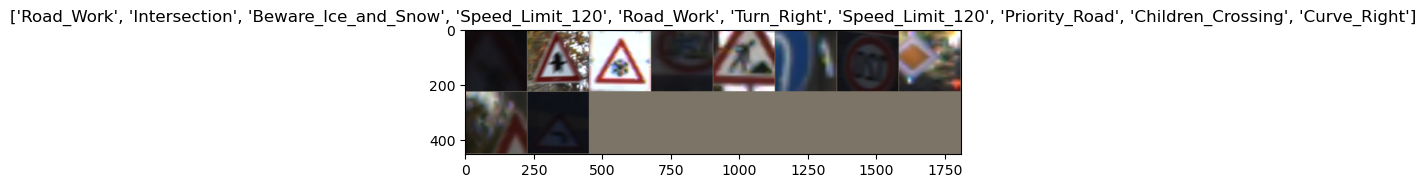

In [7]:
class_ids = ["Speed_Limit_20","Speed_Limit_30","Speed_Limit_50","Speed_Limit_60", "Speed_Limit_70", "Speed_Limit_80",
            "End_Speed_Limit_80","Speed_Limit_100","Speed_Limit_120","No_Passing","No_Passing_Over_3.5m","Intersection",
            "Priority_Road","Yield","Stop","No_Vehicles","Vehicles_over_3.5_prohibited","No_Entry","General_Caution",
            "Curve_Left","Curve_Right","Double_Curve","Bumpy_Road", "Slippery_road","Narrowroad_Right","Road_Work","Traffic_Lights",
            "Pedestrains","Children_Crossing","Bicycles_Crossing","Beware_Ice_and_Snow","Animals_Crossing","End_of_all_speed_limits",
            "Turn_Right","Turn_Left","Ahead_Only","Go_Straight_Right","Go_Straight_Left","Keep_Right","Keep_Left","Roundabout_Mandatory",
            "End_no_passing","End_no_passing_over_3.5"] # class names for each different traffic sign

train_data_path = data_loc+"/Train" #path for train images 

class_names={int(x) : class_ids[int(x)] for x in os.listdir(train_data_path)} #assign class names to their values

dataset_sizes = {'train' : len(dataset_loader["train"].dataset), 'test': len(dataset_loader["test"].dataset)}

print(dataset_sizes) #display sizes of train and test set

train_features, train_labels = next(iter(dataset_loader["train"])) #get a sample of the train set
print(f"Feature batch shape: {train_features.size()}")#print out the shape of the images
print(f"Labels batch shape: {train_labels.size()}") #number of labels/ batch size

# Get a batch of training data
inputs, classes = next(iter(dataset_loader['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

#display the images
showimg(out, title=[class_names[x.item()] for x in classes])


In [8]:
def train_model(model, model_name, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase, for evaluating accuracy over epochs
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for samples, labels in dataset_loader[phase]:
                samples = samples.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(samples)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * samples.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(best_model_wts, "Models/best_"+model_name)
    return model

In [9]:
#download MNIST Dataset, used SOURCE[1] as guide
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (samples, labels) in enumerate(dataset_loader['test']):
            samples, labels =  samples.to(device), labels.to(device)

            outputs = model(samples)
            _, preds = torch.max(outputs, 1)

            for j in range(samples.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j].item()]}')
                showimg(samples.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [10]:
def score_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    correct =0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataset_loader['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                if class_names[preds[j].item()] == class_names[labels[j].item()]:
                    correct += 1 
                    
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return correct/num_images
        model.train(mode=was_training)

In [11]:
def set_requires_grad(model, feature_extract):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False
#models
wideres_model_ft = models.wide_resnet50_2(pretrained=True) #WideResNet
res_model_ft = models.resnet50(pretrained=True) #ResNet
vgg16_model_ft = models.vgg16(pretrained=True) #VGG16
mobilenet_model_ft = models.mobilenet_v3_small(pretrained=True) #MobileNet 

nn_models = {
    "WideResNet": wideres_model_ft,
    "ResNet": res_model_ft,
    "VGG16": vgg16_model_ft,
    "MobileNet" : mobilenet_model_ft
    }

#set the finetuning for each model
def configure_model(model, feature_extract):
    #use feature extraction or fine tuning : boolean 
    set_requires_grad(nn_models[model], feature_extract)
    #freeze layers for each model, change output 
    if model == "WideResNet":
        #get features into final classification layer
        wideres_num_ftrs = nn_models[model].fc.in_features
        #set final classification layer output to number of classes
        nn_models[model].fc = nn.Linear(wideres_num_ftrs, 43)

    if model == "ResNet":
        res_num_ftrs = nn_models[model].fc.in_features
        nn_models[model].fc = nn.Linear(res_num_ftrs, 43)

    if model == "VGG16":
        nn_models[model].classifier[6] =  nn.Linear(4096, 43)
    
    if model == "MobileNet":
        nn_models[model].classifier[3] = nn.Linear(1024, 43)

    #send to gpu for faster processing
    nn_models[model] = nn_models[model].to(device)

#run the configurations and initialize the models
for model in nn_models:
    configure_model(model, False)


c:\Users\teaki\anaconda3\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\teaki\anaconda3\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\teaki\anaconda3\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `wei

In [15]:
#initialize new crtierion for each model
wideres_criterion = nn.CrossEntropyLoss()

# initialize new optimizer for each model
wideres_optimizer_ft = optim.SGD(wideres_model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler1 = lr_scheduler.StepLR(wideres_optimizer_ft, step_size=7, gamma=0.1)

#train the model
wideres_model_ft = train_model(wideres_model_ft, "WideResNet", wideres_criterion, 
                               wideres_optimizer_ft, exp_lr_scheduler1, num_epochs=25)

Epoch 0/24
----------


In [ ]:
res_criterion = nn.CrossEntropyLoss()

res_optimizer_ft = optim.SGD(res_model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(res_optimizer_ft, step_size=7, gamma=0.1)

res_model_ft = train_model(res_model_ft, "ResNet",res_criterion, res_optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7063 Acc: 0.7971
test Loss: 0.1875 Acc: 0.9395

Epoch 1/24
----------
train Loss: 0.3096 Acc: 0.9026
test Loss: 0.1479 Acc: 0.9555

Epoch 2/24
----------
train Loss: 0.2549 Acc: 0.9187
test Loss: 0.1296 Acc: 0.9644

Epoch 3/24
----------
train Loss: 0.2201 Acc: 0.9292
test Loss: 0.1371 Acc: 0.9633

Epoch 4/24
----------
train Loss: 0.2058 Acc: 0.9344
test Loss: 0.1608 Acc: 0.9585

Epoch 5/24
----------
train Loss: 0.1996 Acc: 0.9371
test Loss: 0.1840 Acc: 0.9582

Epoch 6/24
----------
train Loss: 0.1775 Acc: 0.9438
test Loss: 0.1566 Acc: 0.9653

Epoch 7/24
----------
train Loss: 0.1472 Acc: 0.9522
test Loss: 0.1115 Acc: 0.9766

Epoch 8/24
----------
train Loss: 0.1319 Acc: 0.9567
test Loss: 0.1166 Acc: 0.9732

Epoch 9/24
----------
train Loss: 0.1323 Acc: 0.9572
test Loss: 0.1225 Acc: 0.9733

Epoch 10/24
----------
train Loss: 0.1247 Acc: 0.9583
test Loss: 0.1163 Acc: 0.9743

Epoch 11/24
----------
train Loss: 0.1254 Acc: 0.9599
test Loss: 0.1138 Acc

In [ ]:
vgg16_criterion = nn.CrossEntropyLoss()

vgg16_optimizer_ft = optim.SGD(vgg16_model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(vgg16_optimizer_ft, step_size=7, gamma=0.1)

vgg16_model_ft = train_model(vgg16_model_ft,"VGG16", vgg16_criterion, vgg16_optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9273 Acc: 0.7270
test Loss: 0.2762 Acc: 0.9116

Epoch 1/24
----------
train Loss: 0.4786 Acc: 0.8539
test Loss: 0.2109 Acc: 0.9375

Epoch 2/24
----------
train Loss: 0.3891 Acc: 0.8774
test Loss: 0.2579 Acc: 0.9308

Epoch 3/24
----------
train Loss: 0.3517 Acc: 0.8901
test Loss: 0.1786 Acc: 0.9478

Epoch 4/24
----------
train Loss: 0.3062 Acc: 0.9018
test Loss: 0.2220 Acc: 0.9389

Epoch 5/24
----------
train Loss: 0.2918 Acc: 0.9079
test Loss: 0.2139 Acc: 0.9496

Epoch 6/24
----------
train Loss: 0.2715 Acc: 0.9141
test Loss: 0.2050 Acc: 0.9510

Epoch 7/24
----------
train Loss: 0.2029 Acc: 0.9344
test Loss: 0.1540 Acc: 0.9608

Epoch 8/24
----------
train Loss: 0.1837 Acc: 0.9393
test Loss: 0.1593 Acc: 0.9625

Epoch 9/24
----------
train Loss: 0.1766 Acc: 0.9408
test Loss: 0.1704 Acc: 0.9629

Epoch 10/24
----------
train Loss: 0.1781 Acc: 0.9410
test Loss: 0.1599 Acc: 0.9640

Epoch 11/24
----------
train Loss: 0.1732 Acc: 0.9437
test Loss: 0.1709 Acc

In [ ]:
mobile_criterion = nn.CrossEntropyLoss()

mobile_optimizer_ft = optim.SGD(mobilenet_model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(mobile_optimizer_ft, step_size=7, gamma=0.1)

mobilenet_model_ft = train_model(mobilenet_model_ft,"MobileNet", mobile_criterion, 
                                 mobile_optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9747 Acc: 0.7239
test Loss: 0.4962 Acc: 0.8509

Epoch 1/24
----------
train Loss: 0.4094 Acc: 0.8734
test Loss: 0.2010 Acc: 0.9309

Epoch 2/24
----------
train Loss: 0.3272 Acc: 0.8956
test Loss: 0.1675 Acc: 0.9443

Epoch 3/24
----------
train Loss: 0.2836 Acc: 0.9097
test Loss: 0.1560 Acc: 0.9529

Epoch 4/24
----------
train Loss: 0.2615 Acc: 0.9168
test Loss: 0.1718 Acc: 0.9572

Epoch 5/24
----------
train Loss: 0.2415 Acc: 0.9226
test Loss: 0.1960 Acc: 0.9449

Epoch 6/24
----------
train Loss: 0.2282 Acc: 0.9276
test Loss: 0.1748 Acc: 0.9576

Epoch 7/24
----------
train Loss: 0.2085 Acc: 0.9344
test Loss: 0.1446 Acc: 0.9618

Epoch 8/24
----------
train Loss: 0.2003 Acc: 0.9366
test Loss: 0.1373 Acc: 0.9635

Epoch 9/24
----------
train Loss: 0.1972 Acc: 0.9366
test Loss: 0.1327 Acc: 0.9637

Epoch 10/24
----------
train Loss: 0.1995 Acc: 0.9359
test Loss: 0.1363 Acc: 0.9630

Epoch 11/24
----------
train Loss: 0.1941 Acc: 0.9378
test Loss: 0.1356 Acc

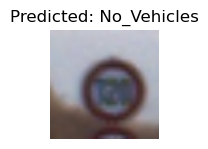

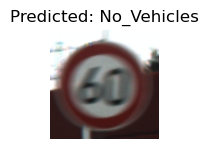

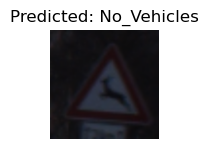

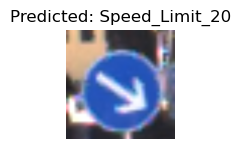

In [19]:

visualize_model(model_ft)

In [12]:
#using traffic sign trained best model with no adversary training
for mdl in nn_models:
    nn_models[mdl].load_state_dict(torch.load("Models/best_"+mdl)) #load the models
    score = score_model(nn_models[mdl],500) #score the models using 500 test images
    print("Model: {}, Accuracy: {}".format(mdl, score))
    

Model: WideResNet, Accuracy: 0.976
Model: ResNet, Accuracy: 0.968
Model: VGG16, Accuracy: 0.962
Model: MobileNet, Accuracy: 0.96


PGD ATTACK

In [1]:
#Source https://github.com/Harry24k/PGD-pytorch/blob/master/PGD.ipynb
def pgd_attack(model, images, labels, epsilon=0.3, alpha=2/255, iters=10):

    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss() #initialise criterion
    #get sign of the data's gradient

    base_img = images.data #store the original image
    for i in range(iters):
        images.requires_grad = True #allow for updating of weights

        output = model(images) #get output of the model

        model.zero_grad() #set the gradients to zero
        cost = loss(output, labels).to(device)
        cost.backward()

        adv_img = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_img - base_img, min=-epsilon, max=epsilon)
        images = torch.clamp(base_img + eta, min=-2, max=2).detach()
            
    return images

In [2]:
#pgd attack test
def pgd_test(model, epsilon, num_images=6):

    # Accuracy counter
    correct = 0
    images_so_far=0
    adv_examples =[]
    # Loop over all examples in test set
    for i, (data, target) in enumerate(dataset_loader['test']):
        if images_so_far >= num_images:
            break
        # Send the data and label to the device
        data = data.to(device)
        target = target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on

        for i in range(len(init_pred)):
            if init_pred[i].item() != target[i].item():
                continue
            
            if images_so_far >= num_images:
                break
            
            images_so_far+=1

            perturbed_data = pgd_attack(model, data, target, epsilon=epsilon)

            output = model(perturbed_data)

            final_pred = output.max(1, keepdim=True)[1]

            if final_pred[i].item() == target[i].item():
                correct += 1
                # Special case for saving 0 epsilon examples
                if (epsilon == 0) and (len(adv_examples) < 5):
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred[i].item(), final_pred[i].item(), adv_ex[i]) )
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred[i].item(), final_pred[i].item(), adv_ex[i]) )
        

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(images_so_far)
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, images_so_far, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

Test attack function

In [13]:
def evaluate_attack(adv_attack, epsilons, accuracy_arr, example_arr):
    # Run test for each epsilon
    for mdl in nn_models:
        accuracies = []
        examples = []
        print(mdl)
        for eps in epsilons:
            acc, ex = adv_attack(nn_models[mdl], eps,10)
            accuracies.append(acc)
            examples.append(ex)
        accuracy_arr[mdl]= accuracies
        example_arr[mdl] = examples


Plot visualisation of the attack

In [19]:
def visualize_attack(accuracies, examples, epsilons):
    for model in accuracies:
        cnt=0
        plt.figure(figsize=(8,10))
        for i in range(len(epsilons)):
            for j in range(len(examples[model][i])):
                cnt+=1
                plt.subplot(len(epsilons), len(examples[model][0]),cnt)
                plt.xticks([], [])
                plt.yticks([], [])
                if j == 0:
                    plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
                orig,adv,ex=examples[model][i][j]
                plt.title('{} -> {}'.format(orig,adv))
                ex = ex.transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                ex = std * ex + mean
                ex = np.clip(ex, 0, 1)
                plt.imshow(ex)
        plt.tight_layout()
        plt.show()

In [17]:
model_pgd_accuracy ={}
model_pgd_examples = {}
epsilons=[0,0.05,0.1,0.15,0.2,0.25,0.3]

# Run test for each epsilon
evaluate_attack(pgd_test, epsilons, model_pgd_accuracy, model_pgd_examples)


WideResNet
Epsilon: 0	Test Accuracy = 10 / 10 = 1.0


KeyboardInterrupt: 

In [20]:
visualize_attack(model_pgd_accuracy, model_pgd_examples, epsilons)

FGSM ATTACK

In [24]:
#next look at FGSM

#perturbed_image=image+epsilon∗sign(data_grad)=x+ϵ∗sign(∇xJ(θ,x,y))
def fgsm_atk(img, epsilon, data_grad):
    #get sign of the data's gradient
    sign_data_grad = data_grad.sign()

    #create the perturbed image by adjusting each pixel of the input image
    perturbed_image = img +(epsilon*sign_data_grad)

    #add clipping to maintain range, changed range to -2,2
    perturbed_image = torch.clamp(perturbed_image, -2,2)

    #Output the perturbed image
    return perturbed_image

In [25]:
#fgsm attack test
def fgsm_test(model, epsilon, num_images=6):

    # Accuracy counter
    correct = 0
    adv_examples = []
    images_so_far=0
    # Loop over all examples in test set
    for i, (data, target) in enumerate(dataset_loader['test']):
        if images_so_far >= num_images*10:
            break
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on

        for i in range(len(init_pred)):
            if init_pred[i].item() != target[i].item():
                continue
            
            if images_so_far >= num_images*10:
                break
            
            images_so_far+=1

            # Calculate the loss
            loss = F.nll_loss(output, target)

            # Zero all existing gradients
            model.zero_grad()

            # Calculate gradients of model in backward pass
            loss.backward()

            # Collect datagrad
            data_grad = data.grad.data

            # Call FGSM Attack
            perturbed_data = fgsm_atk(data, epsilon, data_grad)

            # Re-classify the perturbed image
            output = model(perturbed_data)

            # Check for success
            final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            
            if final_pred[i].item() == target[i].item():
                correct += 1
                # Special case for saving 0 epsilon examples
                if (epsilon == 0) and (len(adv_examples) < 5):
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred[i].item(), final_pred[i].item(), adv_ex[i]) )
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred[i].item(), final_pred[i].item(), adv_ex[i]) )
        

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(images_so_far)
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, images_so_far, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

FGSM RESULTS

In [26]:
model_fgsm_accuracy ={}
model_fgsm_examples = {}
epsilons=[0,0.05,0.1,0.15,0.2,0.25,0.3]

# Run test for each epsilon
evaluate_attack(fgsm_test, epsilons, model_fgsm_accuracy, model_fgsm_examples)



WideResNet


KeyboardInterrupt: 

In [27]:
visualize_attack(model_fgsm_accuracy, model_fgsm_examples, epsilons)

In [ ]:
#adversarial training 

def adversarial_training(model, model_name, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataset_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                

                inputs.requires_grad = True

                outputs = model(inputs)

                loss = criterion(outputs, labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                loss.backward(retain_graph=True)

                data_grad = inputs.grad.data

                perturbed_input = fgsm_atk(inputs, 0.3, data_grad)


                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(perturbed_input)
                    _, preds = torch.max(outputs, 1)
                    loss_adv = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        total_loss = loss + loss_adv
                        total_loss.backward()
                        optimizer.step()

                # statistics
                running_loss += total_loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(best_model_wts, "Models/best_adv_"+model_name)
    return model
#training begins here

Setting Up adversarial Training

In [13]:

def set_requires_grad(model, feature_extract):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False
#models
wideres_model_adv_ft = models.wide_resnet50_2(pretrained=True)
res_model_adv_ft = models.resnet50(pretrained=True)
vgg16_model_adv_ft = models.vgg16(pretrained=True)
mobilenet_model_adv_ft = models.mobilenet_v3_small(pretrained=True)

nn_adv_models = {
    "WideResNet": wideres_model_adv_ft,
    "ResNet": res_model_adv_ft,
    "VGG16": vgg16_model_adv_ft,
    "MobileNet" : mobilenet_model_adv_ft
    }

#set the finetuning for each model
def configure_model(model, feature_extract):
    #use feature extraction or fine tuning : boolean 
    set_requires_grad(nn_adv_models[model], feature_extract)
    #freeze layers for each model, change output 
    if model == "WideResNet":
        #get features into final classification layer
        wideres_num_ftrs = nn_adv_models[model].fc.in_features
        #set final classification layer output to number of classes
        nn_adv_models[model].fc = nn.Linear(wideres_num_ftrs, 43)

    if model == "ResNet":
        res_num_ftrs = nn_adv_models[model].fc.in_features
        nn_adv_models[model].fc = nn.Linear(res_num_ftrs, 43)

    if model == "VGG16":
        nn_adv_models[model].classifier[6] =  nn.Linear(4096, 43)
    
    if model == "MobileNet":
        nn_adv_models[model].classifier[3] = nn.Linear(1024, 43)

    #send to gpu for faster processing
    nn_adv_models[model] = nn_adv_models[model].to(device)

#run the configurations and initialize the models
for model in nn_adv_models:
    configure_model(model, False)





c:\Users\teaki\anaconda3\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\teaki\anaconda3\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\teaki\anaconda3\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `wei

In [ ]:
#initialise criterion for each model
wideres_adv_criterion = nn.CrossEntropyLoss()

# initialize new optimizer for each model
wideres_optimizer_adv_ft = optim.SGD(wideres_model_adv_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
adv_exp_lr_scheduler1 = lr_scheduler.StepLR(wideres_optimizer_adv_ft, step_size=7, gamma=0.1)

wideres_model_adv_ft = adversarial_training(wideres_model_adv_ft,"0.3_WideResNet", wideres_adv_criterion, 
                                            wideres_optimizer_adv_ft, adv_exp_lr_scheduler1, num_epochs=25)

Epoch 0/24
----------


KeyboardInterrupt: 

In [ ]:

res_adv_criterion = nn.CrossEntropyLoss()

res_optimizer_adv_ft = optim.SGD(res_model_adv_ft.parameters(), lr=0.001, momentum=0.9)

adv_exp_lr_scheduler2 = lr_scheduler.StepLR(res_optimizer_adv_ft, step_size=7, gamma=0.1)

res_model_adv_ft = adversarial_training(res_model_adv_ft, "0.3_ResNet",res_adv_criterion, 
                                        res_optimizer_adv_ft, adv_exp_lr_scheduler2, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.5379 Acc: 0.7335
test Loss: 0.2708 Acc: 0.8834

Epoch 1/24
----------
train Loss: 0.7545 Acc: 0.8569
test Loss: 0.8345 Acc: 0.9173

Epoch 2/24
----------
train Loss: 0.6182 Acc: 0.8856
test Loss: 0.8225 Acc: 0.9317

Epoch 3/24
----------
train Loss: 0.5336 Acc: 0.9032
test Loss: 1.3593 Acc: 0.9366

Epoch 4/24
----------
train Loss: 0.4793 Acc: 0.9186
test Loss: 0.0729 Acc: 0.9340

Epoch 5/24
----------
train Loss: 0.4352 Acc: 0.9267
test Loss: 1.0447 Acc: 0.9187

Epoch 6/24
----------
train Loss: 0.3997 Acc: 0.9344
test Loss: 0.1257 Acc: 0.9528

Epoch 7/24
----------
train Loss: 0.2893 Acc: 0.9556
test Loss: 0.3599 Acc: 0.9658

Epoch 8/24
----------
train Loss: 0.2678 Acc: 0.9592
test Loss: 0.0018 Acc: 0.9629

Epoch 9/24
----------
train Loss: 0.2527 Acc: 0.9609
test Loss: 0.0047 Acc: 0.9626

Epoch 10/24
----------
train Loss: 0.2455 Acc: 0.9630
test Loss: 0.1428 Acc: 0.9595

Epoch 11/24
----------
train Loss: 0.2321 Acc: 0.9660
test Loss: 0.4443 Acc

In [ ]:
vgg16_adv_criterion = nn.CrossEntropyLoss()
vgg16_optimizer_adv_ft = optim.SGD(vgg16_model_adv_ft.parameters(), lr=0.001, momentum=0.9)

adv_exp_lr_scheduler = lr_scheduler.StepLR(vgg16_optimizer_adv_ft, step_size=7, gamma=0.1)


vgg16_model_adv_ft = adversarial_training(vgg16_model_adv_ft,"0.3_VGG16", vgg16_adv_criterion, 
                                          vgg16_optimizer_adv_ft, adv_exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.4354 Acc: 0.5946
test Loss: 0.9062 Acc: 0.8667

Epoch 1/24
----------
train Loss: 1.0282 Acc: 0.8516
test Loss: 0.3910 Acc: 0.9483

Epoch 2/24
----------
train Loss: 0.7790 Acc: 0.8946
test Loss: 0.7713 Acc: 0.9476

Epoch 3/24
----------
train Loss: 0.6998 Acc: 0.9048
test Loss: 0.1519 Acc: 0.9423

Epoch 4/24
----------
train Loss: 0.6113 Acc: 0.9202
test Loss: 0.0827 Acc: 0.9656

Epoch 5/24
----------
train Loss: 0.5776 Acc: 0.9264
test Loss: 0.7508 Acc: 0.9637

Epoch 6/24
----------
train Loss: 0.5335 Acc: 0.9332
test Loss: 0.4664 Acc: 0.9548

Epoch 7/24
----------
train Loss: 0.3623 Acc: 0.9547
test Loss: 1.2923 Acc: 0.9683

Epoch 8/24
----------
train Loss: 0.3173 Acc: 0.9624
test Loss: 0.7523 Acc: 0.9709

Epoch 9/24
----------
train Loss: 0.2987 Acc: 0.9653
test Loss: 0.3984 Acc: 0.9721

Epoch 10/24
----------
train Loss: 0.2840 Acc: 0.9681
test Loss: 0.2889 Acc: 0.9750

Epoch 11/24
----------
train Loss: 0.2814 Acc: 0.9685
test Loss: 0.8734 Acc

In [ ]:
mobile_adv_criterion = nn.CrossEntropyLoss()

mobile_optimizer_adv_ft = optim.SGD(mobilenet_model_adv_ft.parameters(), lr=0.001, momentum=0.9)

adv_exp_lr_scheduler = lr_scheduler.StepLR(mobile_optimizer_adv_ft, step_size=7, gamma=0.1)

mobilenet_model_adv_ft = adversarial_training(mobilenet_model_adv_ft,"0.3_MobileNet", mobile_adv_criterion, 
                                              mobile_optimizer_adv_ft, adv_exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.7630 Acc: 0.6772
test Loss: 1.3323 Acc: 0.8002

Epoch 1/24
----------
train Loss: 0.8250 Acc: 0.8418
test Loss: 0.5414 Acc: 0.8830

Epoch 2/24
----------
train Loss: 0.5287 Acc: 0.9194
test Loss: 0.0228 Acc: 0.8993

Epoch 3/24
----------
train Loss: 0.4070 Acc: 0.9527
test Loss: 0.2749 Acc: 0.9267

Epoch 4/24
----------
train Loss: 0.3806 Acc: 0.9574
test Loss: 0.0047 Acc: 0.9059

Epoch 5/24
----------
train Loss: 0.3529 Acc: 0.9595
test Loss: 0.3730 Acc: 0.9032

Epoch 6/24
----------
train Loss: 0.3958 Acc: 0.9437
test Loss: 1.2613 Acc: 0.8508

Epoch 7/24
----------
train Loss: 0.3335 Acc: 0.9546
test Loss: 0.4703 Acc: 0.9102

Epoch 8/24
----------
train Loss: 0.2857 Acc: 0.9644
test Loss: 0.0135 Acc: 0.9148

Epoch 9/24
----------
train Loss: 0.2722 Acc: 0.9675
test Loss: 0.0030 Acc: 0.9256

Epoch 10/24
----------
train Loss: 0.2650 Acc: 0.9680
test Loss: 0.0016 Acc: 0.9195

Epoch 11/24
----------
train Loss: 0.2574 Acc: 0.9692
test Loss: 0.0314 Acc

In [14]:
#using traffic sign trained best model
for mdl in nn_adv_models:
    nn_adv_models[mdl].load_state_dict(torch.load("Models/best_adv_0.3_"+mdl))
    adv_score = score_model(nn_adv_models[mdl],1000)
    print("Model: {}, Accuracy: {}".format(mdl, adv_score))

Model: WideResNet, Accuracy: 0.873
Model: ResNet, Accuracy: 0.835
Model: VGG, Accuracy: 0.967
Model: MobileNet, Accuracy: 0.942


In [26]:
score_model(wideres_model_adv_ft, 5000)
score_model(res_model_adv_ft, 5000)
score_model(vgg16_model_adv_ft, 5000)
score_model(mobilenet_model_adv_ft, 5000)


0.9358

In [15]:

#models
wideres_model_adv2_ft = models.wide_resnet50_2(pretrained=True)


#freeze layers for each model, change output 
wideres_num_ftrs = wideres_model_adv2_ft.fc.in_features

wideres_model_adv2_ft.fc = nn.Linear(wideres_num_ftrs, 43)

#send models to GPU for training
wideres_model_adv2_ft = wideres_model_adv2_ft.to(device)

nn_adv2_models = {
    "WideResNet": wideres_model_adv2_ft,

    }

In [19]:
for mdl in nn_adv2_models:
    nn_adv2_models[mdl].load_state_dict(torch.load("Models/best_adv_2_0.1_"+mdl))
    adv_score = score_model(nn_adv2_models[mdl],1000)
    print("Model: {}, Accuracy: {}".format(mdl, adv_score))

Model: WideResNet, Accuracy: 0.946


In [20]:
model_fgsm_accuracy ={}
model_fgsm_examples = {}
epsilons=[0,0.05,0.1,0.15,0.2,0.25,0.3]

# Run test for each epsilon
for mdl in nn_adv2_models:
    accuracies = []
    examples = []
    print(mdl)
    for eps in epsilons:
        acc, ex = fgsm_test(nn_adv2_models[mdl], eps,10)
        accuracies.append(acc)
        examples.append(ex)
    model_fgsm_accuracy[mdl]= accuracies
    model_fgsm_examples[mdl] = examples

WideResNet
Epsilon: 0	Test Accuracy = 99 / 100 = 0.99
Epsilon: 0.05	Test Accuracy = 85 / 100 = 0.85
Epsilon: 0.1	Test Accuracy = 79 / 100 = 0.79
Epsilon: 0.15	Test Accuracy = 72 / 100 = 0.72
Epsilon: 0.2	Test Accuracy = 51 / 100 = 0.51
Epsilon: 0.25	Test Accuracy = 40 / 100 = 0.4
Epsilon: 0.3	Test Accuracy = 38 / 100 = 0.38


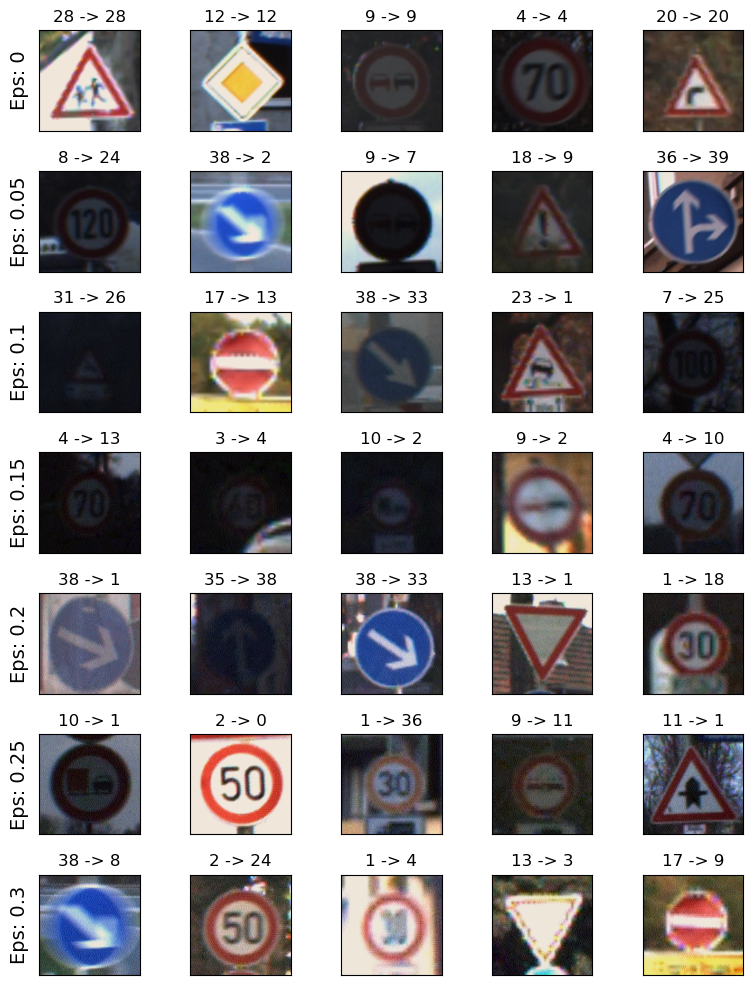

In [19]:
visualize_attack(model_fgsm_accuracy, model_fgsm_examples, epsilons)

test using different models, accuracy vs robustness
and different attacks fgsm, pgd etc
use normal generation method / experiment with GAN if there is time